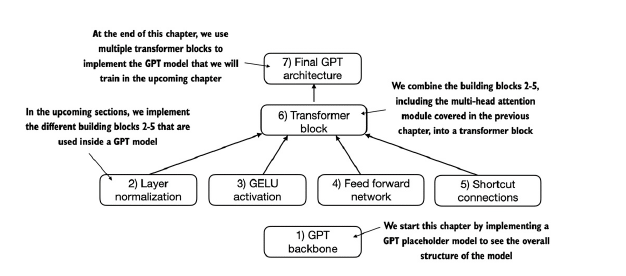

## 4.1 Coding an LLM architecture

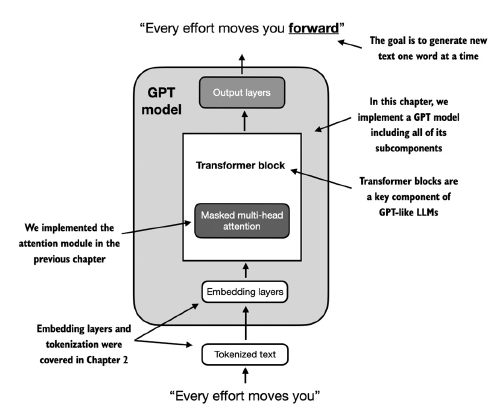

In [7]:
import torch # type: ignore
import torch.nn as nn # type: ignore

class DummyTransformerBlock(nn.Module): 
  def __init__(self, cfg):
    super().__init__()
  def forward(self, x): 
    return x

class DummyLayerNorm(nn.Module): 
  def __init__(self, normalized_shape, eps=1e-5): 
    super().__init__()
  def forward(self, x):
    return x

class DummyGPTModel(nn.Module):
  def __init__(self,config):
    super().__init__()
    self.tok_emb= nn.Embedding(config["vocab_size"],config["emb_dim"])
    self.pos_emb = nn.Embedding(config["context_length"],config["emb_dim"])
    self.dropout = nn.Dropout(config["drop_rate"])

    self.trf_blocks = nn.Sequential(*[DummyTransformerBlock(config) for _ in range(config["n_layers"])])
    self.final_norm = DummyLayerNorm(config)
    self.out_head = nn.Linear(config["emb_dim"], config["vocab_size"], bias = False)
  
  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.dropout(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits


In [5]:
GPT_CONFIG_124M = {
"vocab_size": 50257, # Vocabulary size
"context_length": 1024, # Context length
"emb_dim": 768, # Embedding dimension
"n_heads": 12, # Number of attention heads
"n_layers": 12, # Number of layers
"drop_rate": 0.1, # Dropout rate
"qkv_bias": False # Query-Key-Value bias
}

import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [8]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)
